# IMT TAF Fiabilité : Test de charge

- **durée** 30s

In [10]:
%matplotlib inline
%config InlineBackend.rc = {'font.size': 10, 'figure.figsize': (16.0, 5.0),'figure.dpi': 75}
import pandas as pd
from matplotlib import pyplot as plt #%matplotlib notebook

In [20]:
d = pd.read_csv('data/stats.csv', parse_dates=['ts'], date_parser=lambda x: pd.to_datetime(x, unit='ms').tz_localize('UTC').tz_convert('Europe/Paris'),
                                names=['id','ts','path','latency','res','res_desc'])
d["grouppath"] = d.apply(lambda x: "/".join(x['path'].split("/")[:2]), axis=1)
sorted_data = d.sample(33).sort_values(by="latency" , ascending = False)
filterd_data = sorted_data[sorted_data["grouppath"] == "/order"]
filterd_data

/tmp/ipykernel_87025/785509217.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  d = pd.read_csv('data/stats.csv', parse_dates=['ts'], date_parser=lambda x: pd.to_datetime(x, unit='ms').tz_localize('UTC').tz_convert('Europe/Paris'),
/tmp/ipykernel_87025/785509217.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  d = pd.read_csv('data/stats.csv', parse_dates=['ts'], date_parser=lambda x: pd.to_datetime(x, unit='ms').tz_localize('UTC').tz_convert('Europe/Paris'),


,id,ts,path,latency,res,res_desc,grouppath
19,15,2024-10-08 15:53:28.064000+02:00,/order,4770,ok,200,/order
7,900000002,2024-10-08 15:51:16.992000+02:00,/order/2/payment-callback',3970,ok,200,/order
6,6,2024-10-08 15:51:16.992000+02:00,/order,3762,ok,200,/order
2,2,2024-10-08 15:51:16.992000+02:00,/order,2822,ok,200,/order
16,14,2024-10-08 15:53:28.064000+02:00,/order,2758,ok,200,/order
20,900000014,2024-10-08 15:53:28.064000+02:00,/order/14/payment-callback',2219,ok,200,/order
24,900000015,2024-10-08 15:53:28.064000+02:00,/order/15/payment-callback',2043,ok,200,/order
11,900000006,2024-10-08 15:53:28.064000+02:00,/order/6/payment-callback',1935,ok,200,/order


## Indicateurs - résumé

In [12]:
d.describe()

,id,latency,res_desc
count,3.300000e+01,33.000000,33.0
mean,1.090909e+08,1120.060606,200.0
std,2.982906e+08,1406.569340,0.0
min,0.000000e+00,2.000000,200.0
25%,8.000000e+00,6.000000,200.0
50%,1.600000e+01,90.000000,200.0
75%,2.400000e+01,1974.000000,200.0
max,9.000000e+08,4770.000000,200.0


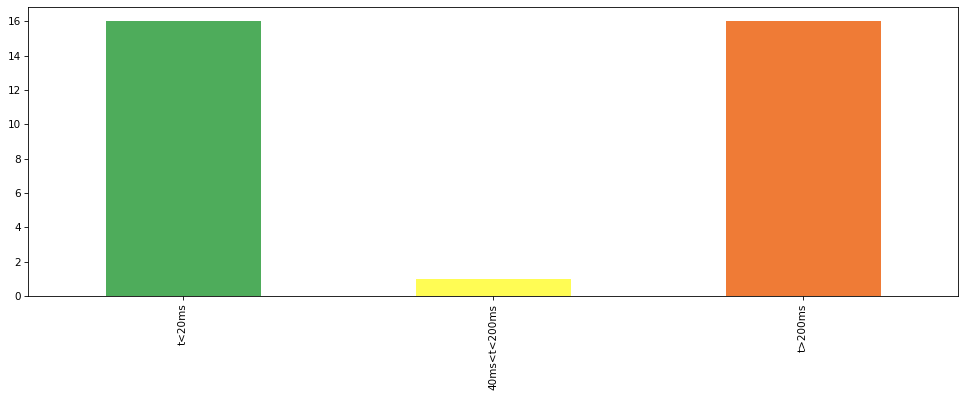

In [13]:
def histogroup(k):
    lat = d['latency'].loc[k]; ok = d['res'].loc[k]
    return "failed" if ok == "ko" else "t<20ms" if lat < 20 else "20ms<t<40ms" if lat < 40 else "40ms<t<200ms" if lat < 200 else "t>200ms"
histo = d.groupby(histogroup)['id'].count()
ordered_labels = ["failed", "t<20ms", "20ms<t<40ms", "40ms<t<200ms", "t>200ms"]; color_dict = {"t<20ms": '#4eac5b', "20ms<t<40ms": '#608ece', "40ms<t<200ms" : '#fffc54', "t>200ms" : '#ef7b36', "failed": 'r'}
histo = histo.reindex(pd.Categorical(histo.index,categories=ordered_labels,ordered=True)).sort_index()
colors = [color_dict[l] for l in histo.index]
histo.plot.bar(color=colors);

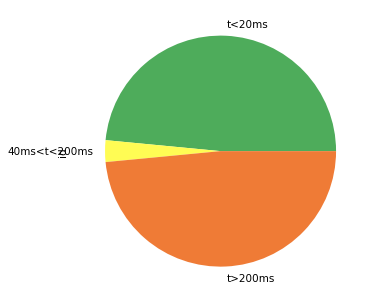

In [14]:
histo.plot.pie(colors=colors,figsize=(5,5));

In [15]:
def okcount(x):
    return x.value_counts().get("ok", 0)
def kocount(x):
    return x.value_counts().get("ko", 0)
def koper(x):
    return 100*(x.value_counts().get("ko", 0) / x.count())
def pct95th(x):
    print(x.values)
    print(x.count())
    print(x.quantile([1]))
    return x.quantile(0.95)
def pct99th(x):
    return x.quantile(0.99)
def reqpersec(x):
    return x.groupby(x.apply(lambda y: y.floor('s'))).count().mean()

#d.groupby(["grouppath"])
d.groupby(["grouppath"]).agg({'res': ['count',okcount,kocount,koper],'latency': ['mean','std','min','max'],'ts': [reqpersec]})
# d.groupby(["grouppath"]).agg({'res': [okcount]})


res                         latency                     \
                 count okcount kocount koper      mean          std   min   
grouppath                                                                   
/aggregate-stats    25      25       0   0.0   507.320   846.478180     2   
/order               8       8       0   0.0  3034.875  1027.826894  1935   

                              ts  
                   max reqpersec  
grouppath                         
/aggregate-stats  2974      12.5  
/order            4770       4.0

## Temps de réponse (ms)

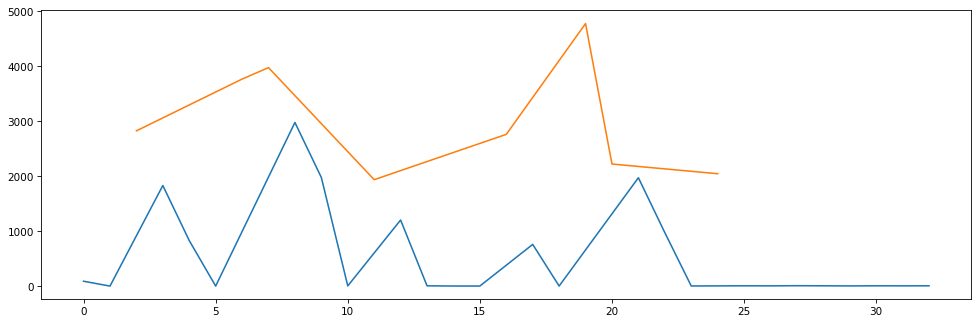

In [16]:
d.groupby(d['grouppath'])['latency'].plot();

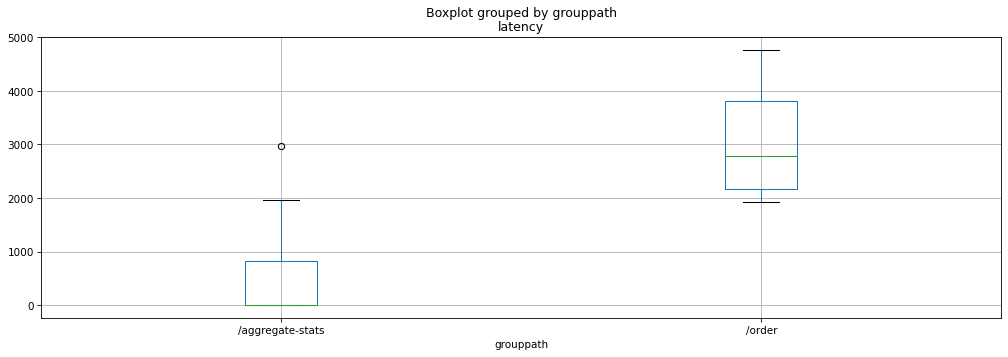

In [17]:
d.boxplot(column=['latency'], by='grouppath');